# Energy Demand Forecasting with TimeGPT

## Introduction

Energy demand forecasting is crucial for:
- Grid management and stability
- Efficient resource allocation
- Cost optimization
- Sustainability planning
- Integration of renewable energy sources

This notebook demonstrates how to use TimeGPT for accurate energy demand forecasting, providing insights that can help utilities and grid operators make informed decisions about energy distribution and capacity planning.

## Setup

First, let's install and import the required packages.

In [1]:
%%capture
!pip install nixtla pandas numpy matplotlib seaborn utilsforecast

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from nixtla import NixtlaClient
from utilsforecast.losses import mae, mse, smape
from utilsforecast.evaluation import evaluate

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [15, 6]

# Initialize Nixtla client
nixtla_client = NixtlaClient(
    api_key='nixak-YdxgHOqWIumbzuaM3A4FiCAaIBp6NLVstE1CjJEnN2Ia9Lu0k6lttUxmz4LZtBNTNV8bYf3owJy6btvb'
)

print("✅ Setup completed successfully")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


✅ Setup completed successfully


## Dataset Generation

We'll create synthetic energy demand data that incorporates typical patterns:
- Daily patterns (peak hours during working hours)
- Weekly patterns (lower demand on weekends)
- Seasonal patterns (higher demand in summer and winter)
- Random variations to simulate real-world fluctuations

<ipython-input-3-ead04a18da6f>:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(start=start_date, end=end_date, freq='H')


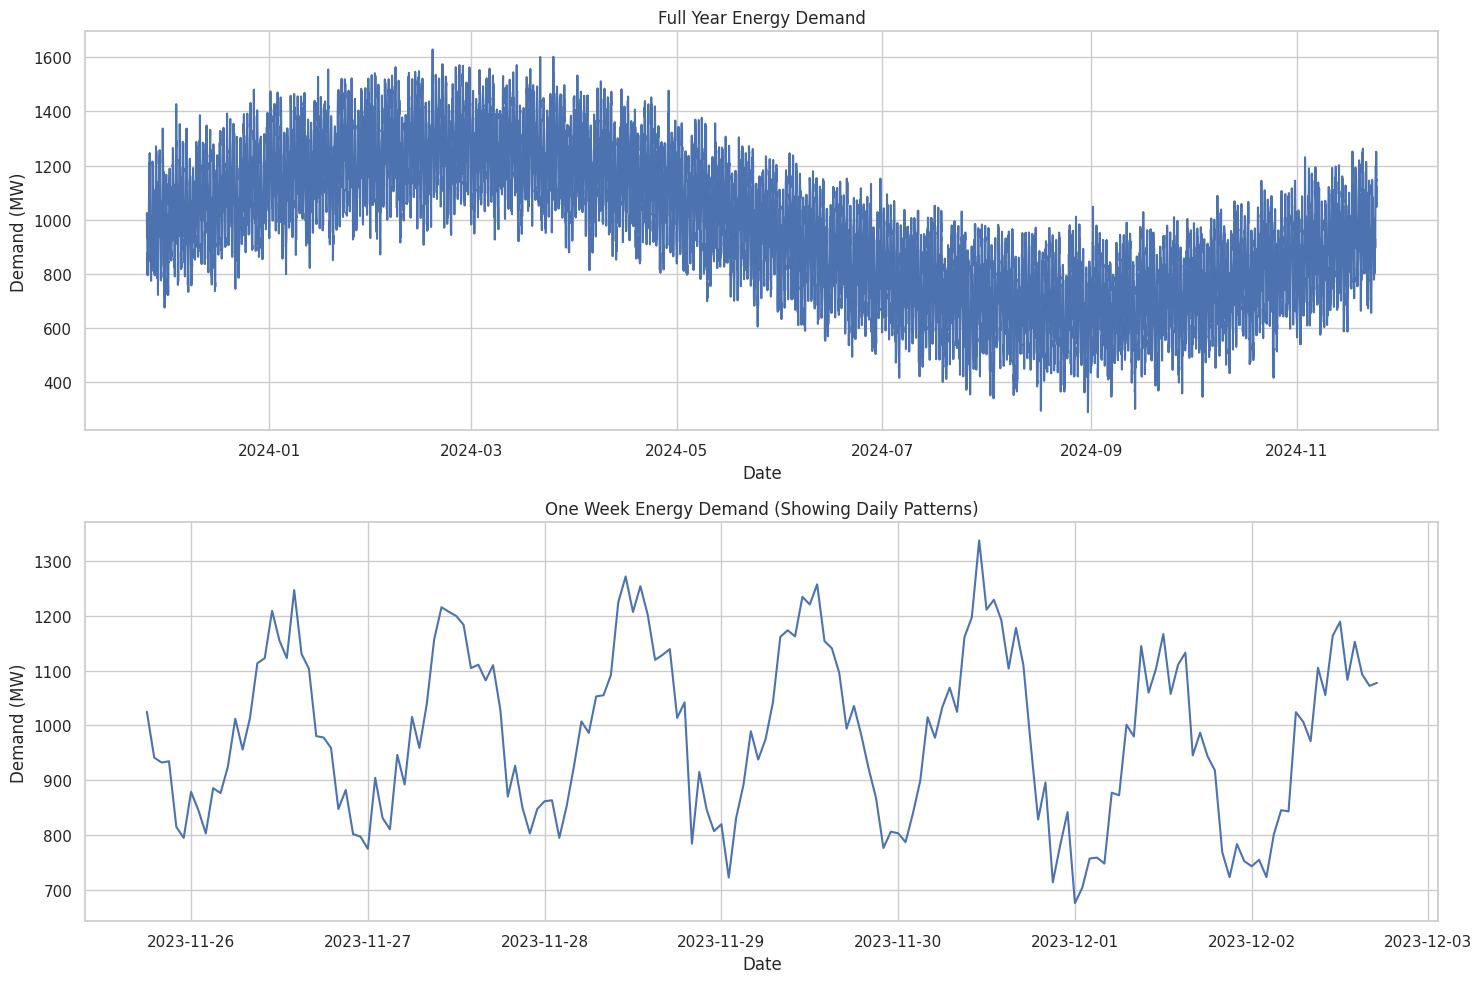

✅ Generated synthetic energy demand data
Total hours: 8761
Date range: 2023-11-25 18:00:00 to 2024-11-24 18:00:00


In [3]:
def generate_energy_demand(days=365):
    """
    Generate synthetic hourly energy demand data.

    Parameters:
    -----------
    days : int
        Number of days of data to generate

    Returns:
    --------
    pd.DataFrame
        DataFrame with columns: unique_id, ds, y
    """
    # Generate hourly timestamps
    end_date = datetime.now().replace(minute=0, second=0, microsecond=0)
    start_date = end_date - timedelta(days=days)
    timestamps = pd.date_range(start=start_date, end=end_date, freq='H')

    # Generate components
    hours = len(timestamps)
    t = np.arange(hours)

    # 1. Base load (constant component)
    base_load = 1000

    # 2. Daily pattern (24-hour cycle)
    hour_of_day = t % 24
    daily_pattern = 200 * np.sin(2 * np.pi * (hour_of_day - 12) / 24)  # Peak at noon

    # 3. Weekly pattern (7-day cycle)
    day_of_week = (t // 24) % 7
    weekend_mask = (day_of_week >= 5)  # Weekend effect
    weekly_pattern = -100 * weekend_mask  # Lower demand on weekends

    # 4. Seasonal pattern (365-day cycle)
    day_of_year = (t // 24) % 365
    seasonal_pattern = 300 * np.sin(2 * np.pi * day_of_year / 365)  # Peak in summer

    # 5. Random variations
    noise = np.random.normal(0, 50, hours)

    # Combine all components
    demand = base_load + daily_pattern + weekly_pattern + seasonal_pattern + noise

    # Create DataFrame
    df = pd.DataFrame({
        'unique_id': 'region_1',
        'ds': timestamps,
        'y': demand
    })

    return df

# Generate dataset
df = generate_energy_demand()

# Plot the data
plt.figure(figsize=(15, 10))

# Plot full time series
plt.subplot(2, 1, 1)
plt.plot(df['ds'], df['y'])
plt.title('Full Year Energy Demand')
plt.xlabel('Date')
plt.ylabel('Demand (MW)')

# Plot one week of data to show daily patterns
week_data = df.iloc[:24*7]
plt.subplot(2, 1, 2)
plt.plot(week_data['ds'], week_data['y'])
plt.title('One Week Energy Demand (Showing Daily Patterns)')
plt.xlabel('Date')
plt.ylabel('Demand (MW)')

plt.tight_layout()
plt.show()

print("✅ Generated synthetic energy demand data")
print(f"Total hours: {len(df)}")
print(f"Date range: {df['ds'].min()} to {df['ds'].max()}")

## Energy Demand Forecasting

Now we'll use TimeGPT to forecast energy demand for the next 30 days. We'll:
1. Split the data into training and test sets
2. Generate forecasts with confidence intervals
3. Evaluate the model's performance

Training data: 8041 hours
Test data: 720 hours


/usr/local/lib/python3.10/dist-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.10/dist-packages/utilsforecast/processing.py:384: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.10/dist-packages/utilsforecast/processing.py:440: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)



Forecast Evaluation Metrics:


,unique_id,metric,TimeGPT
0,region_1,mae,47.389699
1,region_1,mse,3573.677610
2,region_1,smape,0.027506


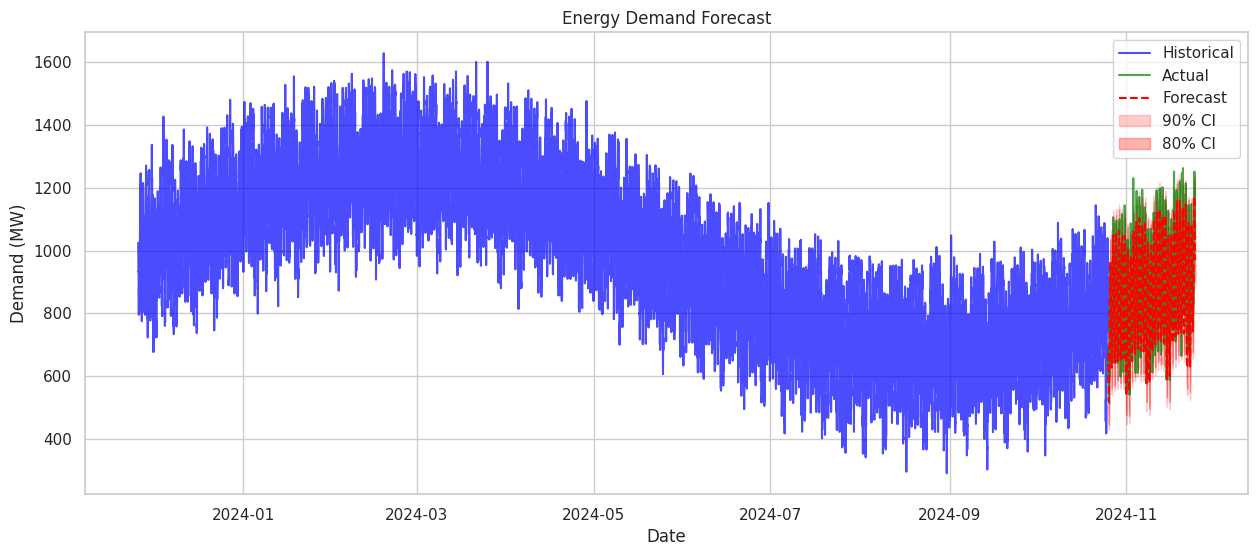

In [4]:
# Split data into train and test
test_hours = 24 * 30  # 30 days for testing
train_df = df.iloc[:-test_hours].copy()
test_df = df.iloc[-test_hours:].copy()

print(f"Training data: {len(train_df)} hours")
print(f"Test data: {len(test_df)} hours")

# Generate forecasts
fcst_df = nixtla_client.forecast(
    df=train_df,
    h=test_hours,
    level=[80, 90],  # Generate 80% and 90% confidence intervals
    freq='H',
    finetune_steps=10,  # Fine-tune the model
    finetune_loss='mae',  # Use MAE as the loss function
    model='timegpt-1-long-horizon',  # Use long-horizon model for multi-day forecasts
    time_col='ds',
    target_col='y',
    id_col='unique_id'
)

# Evaluate forecasts
evaluation_df = pd.merge(test_df, fcst_df, on=['unique_id', 'ds'], how='left')

metrics = evaluate(
    evaluation_df,
    metrics=[mae, mse, smape],
    models=['TimeGPT'],
    target_col='y',
    id_col='unique_id'
)

print("\nForecast Evaluation Metrics:")
display(metrics)

# Plot results
plt.figure(figsize=(15, 6))

# Plot historical data
plt.plot(train_df['ds'], train_df['y'],
         label='Historical', color='blue', alpha=0.7)

# Plot test data
plt.plot(test_df['ds'], test_df['y'],
         label='Actual', color='green', alpha=0.7)

# Plot forecast
plt.plot(fcst_df['ds'], fcst_df['TimeGPT'],
         label='Forecast', color='red', linestyle='--')

# Plot confidence intervals
plt.fill_between(fcst_df['ds'],
                 fcst_df['TimeGPT-lo-90'],
                 fcst_df['TimeGPT-hi-90'],
                 alpha=0.2,
                 color='red',
                 label='90% CI')

plt.fill_between(fcst_df['ds'],
                 fcst_df['TimeGPT-lo-80'],
                 fcst_df['TimeGPT-hi-80'],
                 alpha=0.3,
                 color='red',
                 label='80% CI')

plt.title('Energy Demand Forecast')
plt.xlabel('Date')
plt.ylabel('Demand (MW)')
plt.legend()
plt.grid(True)
plt.show()

## Analysis of Daily Patterns

Let's examine the forecast accuracy for different times of day.

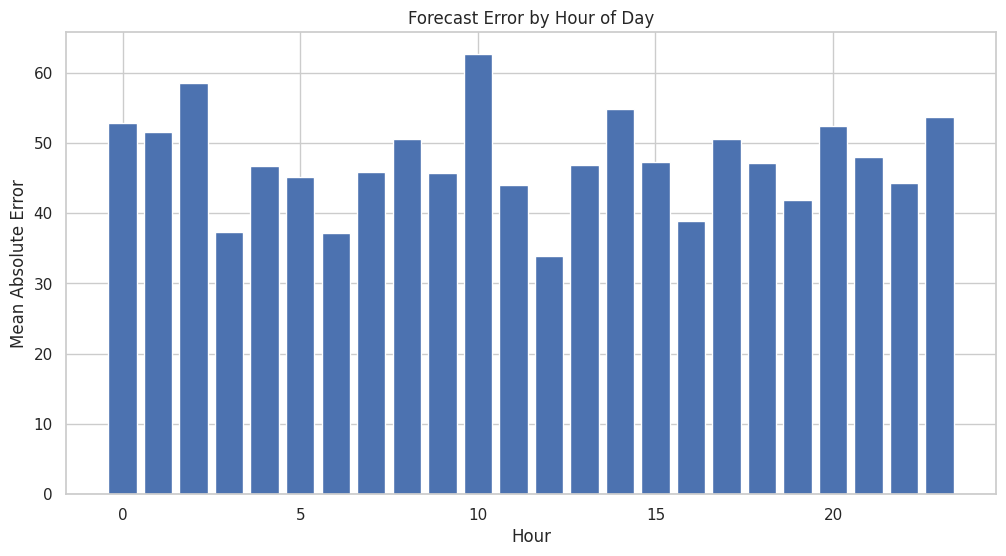

Hours with highest forecast error:


,Hour,MAE
10,10,62.615757
2,2,58.498504
14,14,54.835267
23,23,53.646946
0,0,52.813952



Hours with highest average demand:


,Hour,Average Demand
11,11,1094.117539
13,13,1091.128004
12,12,1088.814313
10,10,1067.402845
14,14,1066.514501


In [5]:
# Add hour of day
evaluation_df['hour'] = evaluation_df['ds'].dt.hour

# Calculate hourly MAE manually
hourly_errors = []
for hour in range(24):
    hour_data = evaluation_df[evaluation_df['hour'] == hour]
    hour_mae = np.mean(np.abs(hour_data['y'] - hour_data['TimeGPT']))
    hourly_errors.append({'Hour': hour, 'MAE': hour_mae})

hourly_mae = pd.DataFrame(hourly_errors)

# Plot hourly MAE
plt.figure(figsize=(12, 6))
plt.bar(hourly_mae['Hour'], hourly_mae['MAE'])
plt.title('Forecast Error by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Mean Absolute Error')
plt.grid(True)
plt.show()

print("Hours with highest forecast error:")
display(hourly_mae.nlargest(5, 'MAE'))

# Calculate average demand by hour for comparison
hourly_demand = evaluation_df.groupby('hour')['y'].mean().reset_index()
hourly_demand.columns = ['Hour', 'Average Demand']

print("\nHours with highest average demand:")
display(hourly_demand.nlargest(5, 'Average Demand'))

## Conclusion

This notebook demonstrated TimeGPT's capabilities for energy demand forecasting:

1. We generated synthetic energy demand data incorporating:
   - Daily patterns (peak hours)
   - Weekly patterns (weekend effects)
   - Seasonal patterns (yearly cycles)

2. Used TimeGPT to generate 30-day forecasts with:
   - 80% and 90% confidence intervals
   - Fine-tuning for improved accuracy

3. Evaluated the forecasts using multiple metrics:
   - Mean Absolute Error (MAE)
   - Mean Squared Error (MSE)
   - Symmetric Mean Absolute Percentage Error (sMAPE)

4. Analyzed forecast accuracy by hour of day, revealing:
   - Which hours have the highest forecast errors
   - Relationship between demand levels and forecast accuracy

Key findings:
- TimeGPT effectively captured both short-term (daily) and long-term (seasonal) patterns
- The model's confidence intervals provide useful uncertainty estimates
- Certain hours of the day show higher forecast uncertainty
- Peak demand hours tend to have higher forecast errors

This demonstrates TimeGPT's potential for real-world energy demand forecasting applications, where accurate predictions are crucial for grid management and resource planning.